# Simple classification and regression tutorial

In this section we will cover the basic API of PyTorch network models and use it to create first a simple logistic regression trained on simulated data. Following this we will train an multi-layer perceptron (MLP) followed by a simple convolutional neural network to perform classification of the MNIST dataset.

First load basic modules


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F #contains some useful functions like activation functions & convolution operations you can use

device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")


## GPU or CPU?

Before we can even begin, we need to know whether we are using a GPU or a CPU. If its the former, the model and all the data should be uploaded into the GPU. Fortunately, we can define a variable "device" that will either be cpu or gpu depending on availability, and load the data automatically on the correct 'device'.

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device) 

cpu


We see that if cuda is available our model will be run on a GPU, otherwise the model will need to run on CPU.

## Defining a network class

We can define a class network in pytorch, in two steps, by inheriting `nn.Module` :

1. The first part is creation of the constructor `__init__` in which you must define all parameters and layers that you will use
2. The second part is to define the forward pass through the function `forward(self,x)` which takes in input and calculates the output.

Note, backpropagation is automatically defined by autograd and this does not need to be explicitely coded up.
Once complete, you can then create an instance of the class using `net = Model()`. 

Example:

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(64)
        
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(320, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        return F.log_softmax(x)

net = Model()


This network contains 2 convolutional layers, and one fully connected layer. The first convolution has a kernel of [5x5] takes an 2D image with 3 channels, and outputs 64 channels.  The second convolution also has a kernel of [5x5],  but takes the 64 channels output from convolution 1 and outputs 128 channels. Both layers are implemented with ReLu activation and batchnorm. After the convolutional layers the data is reshaped using `x.view(-1, 320)`, which allows it to be fed into the final FC layer (which expects a vector). The last step is a softmax activation function.

### Loss Function
The loss function is used to measure how well the prediction model is able to predict the expected results. PyTorch already has many standard loss functions in the torch.nn module. For example, you can use the Cross-Entropy Loss to solve a multi-class classification problem, or a mean squared error (MSE) loss for regression. 

For example, to define the loss function and compute the losses:

```python
loss_CE = nn.CrossEntropyLoss()
loss_MSE = nn.MSELoss()

#training process
loss = loss_CE(prediction, target)
```

### Optimizer
There are many optmizers available in pytorch - see https://pytorch.org/docs/stable/optim.html for full list and further examples.

You define an optmizer in the following way:

```python
optim = torch.optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
```


### Backprop and clearing gradients
To perform the backpropagation, you call the loss.backward(), followed by optim.step(). **You should clear gradients before every training iteration to ensure there's no gradients remaining**. This is to avoid mixing up gradients between minibatches. More specifically however, it is an sideeffect of the fact that PyTorch implements dynamic computation graphs as opposed to static ones (like tensorflow). In addition, the fact that the backward() function in Pytorch accumulates gradients is useful for Recurrent Neural Networks and complex networks with multiple different parts.

```python
net.zero_grad() # to clear the existing gradient - this should be done prior to a training pass
optim.zero_grad() # to clear gradient in optimizer - this is equivalent to net.zero_grad(). 
loss.backward() # to perform backpropragation - accumulates the gradient (by addition) for each parameter
optim.step() # optimizer.step is performs a parameter update based on the current gradient (stored in .grad attribute of a parameter) and the update rule. 
```

## Sequential Models

It should be clear that as networks become more and more complicated, the forward function can quickly become long and cluttered. For these reasons PyTorch provides functionality to combine steps by stacking Modules in blocks usin `nn.sequential`.

In [4]:
class Model(nn.Module):
 def __init__(self):
        super(Model, self).__init__()
    
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.fc1 = nn.Linear(320, 10)

def forward(self, x):
       x = self.conv_block1(x) 
       x = self.conv_block2(x)
       x = x.view(-1, 320)
       x = F.relu(self.fc1(x))
       return F.log_softmax(x)

net = Model()


Sequential blocks are advantageous as they run faster. The one limitation, however, is that it is then not possible to observe the outputs of the intermediate steps stacked inside. If this is required, an alternative approach  can be to use a `ModudeList` or `ModuleDict`. For more functionality on `nn.sequential` `nn.ModuleList` and `nn.ModuleDict,` please read https://github.com/FrancescoSaverioZuppichini/Pytorch-how-and-when-to-use-Module-Sequential-ModuleList-and-ModuleDict 

## Simple Regression with PyTorch - Predicting a Simple Function

### Creating a simple neural network

We will now go through an example of how to create, train and test a PyTorch implementation of logistic regression (single layer neural network). It takes an input of size [1] and outputs also size [1].


In [5]:

class Net(nn.Module):
   def __init__(self):
       super(Net, self).__init__()
       self.layer = torch.nn.Linear(1, 1)

   def forward(self, x):
       x = self.layer(x)      
       return x

net = Net()
print(net)


Net(
  (layer): Linear(in_features=1, out_features=1, bias=True)
)


### Simulate data using a simple function

We can create simulated data to test our simple regression network. The aim is to use our neural network to estimate/ make predictions. 

We use the following function to randomly generate 100 data points:

$Y = \cos(x) \times x^3 + 4x + 0.6 \times rand()$



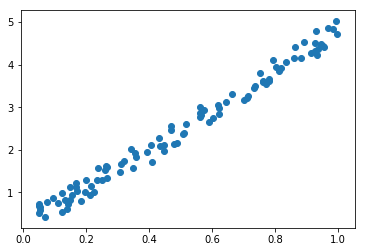

In [6]:
# Visualize our data
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x = np.random.rand(100)
y = np.cos(x) * np.power(x,3) + 4*x + np.random.rand(100)*0.6

plt.scatter(x, y)
plt.show()


Since we're using pytorch, we need to convert our numpy array to a pytorch tensor. The size of the input will be [100, 1], where 100 is the batch size, and 1 is the size of the input (as previously defined in our neural network).

In [7]:
# convert numpy array to tensor in shape of input size
x = torch.from_numpy(x.reshape(-1,1)).float()
y = torch.from_numpy(y.reshape(-1,1)).float()
print(x.size(), y.size())


torch.Size([100, 1]) torch.Size([100, 1])


### Define the optmizer and loss function

We next define our optimizer and loss function. Since we are performing regression, the loss function we chose is Mean Squared Error, or l2 loss. Another common loss function for regression is the Mean Absolute Error, or l1 loss.


In [8]:
# Define Optimizer and Loss Function
#------------------------------------------------------task 1----------------------------------------------------------------
# Task 1: change optimizer here
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
# Task 1: change loss function here
loss_func = torch.nn.MSELoss()
loss_func = torch.nn.L1Loss()
#----------------------------------------------------------------------------------------------------------------------------


### Training

During training we iterate through our data. Here we use number of epochs = 200, but the optimal number largely depends on the dataset and the task.


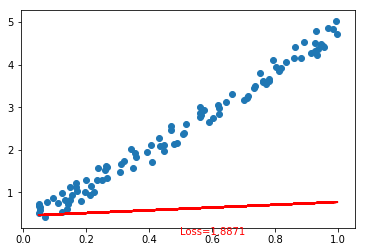

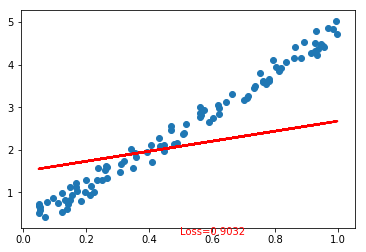

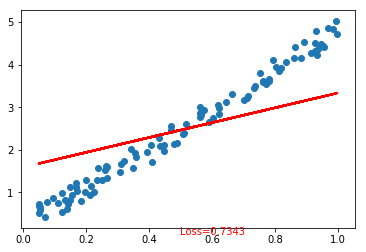

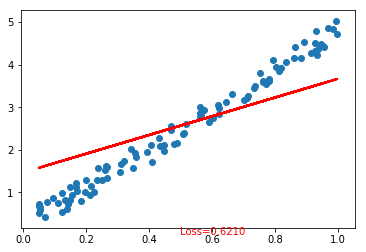

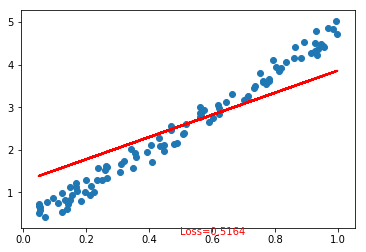

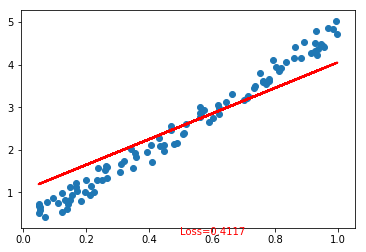

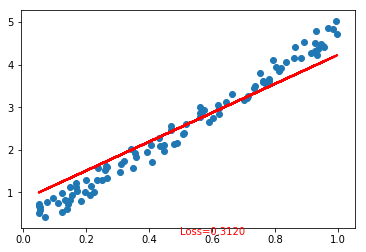

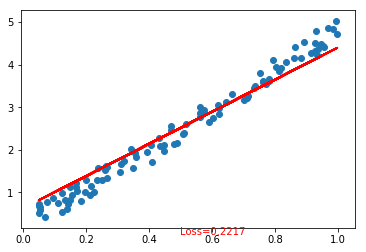

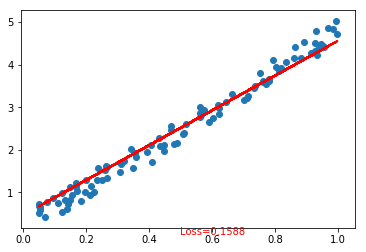

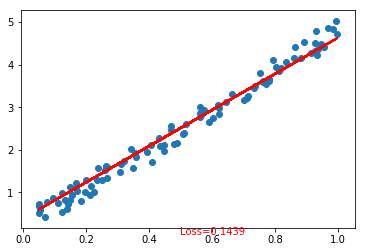

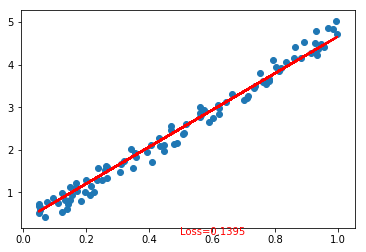

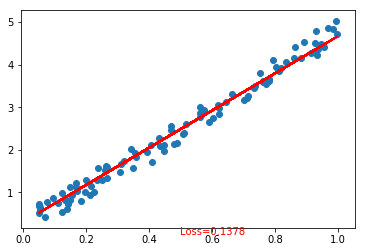

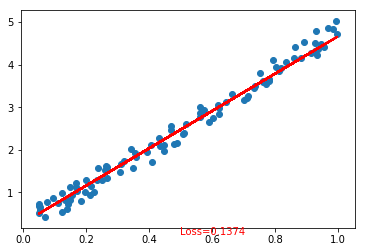

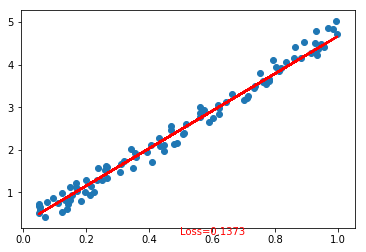

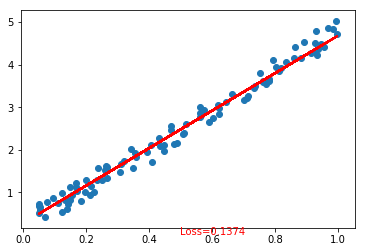

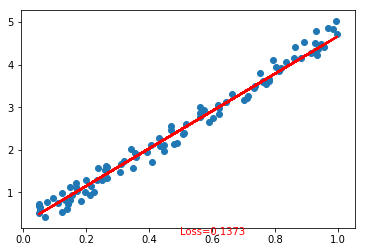

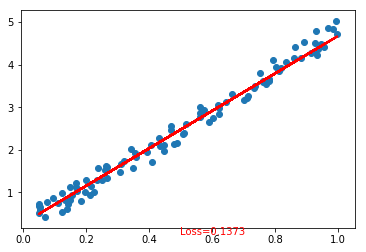

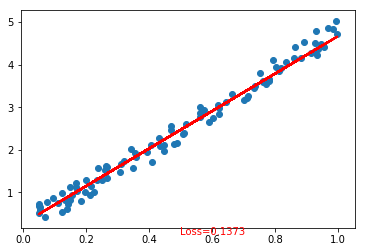

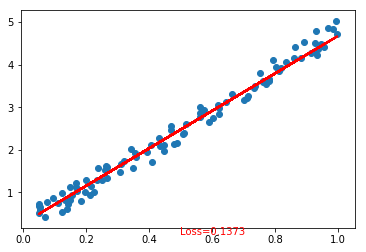

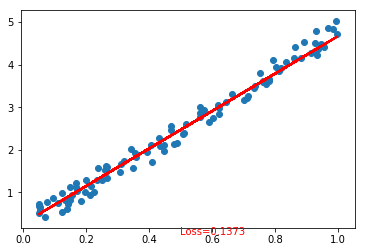

In [9]:
inputs = x 
outputs = y 
epochs = 200
for i in range(epochs):
    optimizer.zero_grad() # clear gradients - here we could interchangibly use net.zero_grad()
    prediction = net(inputs) # pass data through network
    loss = loss_func(prediction, outputs) # compute loss  
    loss.backward() # accumulate gradients       
    optimizer.step() # update network parameters

    # Display results
    if i % 10 == 0:
        # note how we need to tranform data back to numpy
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=2)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 10, 'color':  'red'})
        plt.pause(0.1)



### Result

We have now set up and performed simple regression with a neural network. You can see the results above, how in every iteration the red line (the prediction) updates, and moves closer to fit the data.

**You can perform regression with any neural network- the important step to remember is that your final layer should be of output size [1], and the loss function you use is suitable for regression - e.g. mean squared error, absolute sqaured error**

### Task 1

1. change the loss function to Mean Absolute Error (l1 loss) - which loss function work better?
2. change the optimiser?

## Image Classification with PyTorch - Handwritten Digit Class Prediction

A very common dataset to learn the basics of deep learning, and even to validate new methods is with the MNIST dataset.
The dataset is a set of 60,000 images of handwritten numbers between 0 - 9, of size [28,28] pixels, with labels.

Here is an example of images from the dataset:

![mnist](mnist.png)



Loading the data again form Torchvision.

In [24]:
import torchvision
import numpy as np
from torchvision import datasets, models, transforms

mnist_train_dataset = datasets.MNIST(root = 'mnist_data/train', download= True, train = True, transform = transforms.ToTensor())
mnist_test_dataset = datasets.MNIST(root = 'mnist_data/test', download= True, train = False, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
       mnist_train_dataset, batch_size= 128, shuffle = True)

test_loader = torch.utils.data.DataLoader(
       mnist_test_dataset, batch_size = 128, shuffle = True)

classes = ('0', '1', '2', '3',
          '4', '5', '6', '7', '8', '9')

The transform function converts the images into tensor and normalizes the value. The function torchvision.transforms.MNIST, will download the dataset (if it's not available) in the directory, set the dataset for training if necessary and do the transformation process.



## MNIST classification using a fully connected (MLP) network

We will make an MLP consisting of three fully connected layers, each followed by an Relu activation layer, with the exception of the final layer, where we use softmax (to output class label probabilities).

We choose, arbitrarily, to have 50 hidden neurons each time. Feel free to change the number of hidden neurons yourself and see how it affects the result.

After defining the layers of our module, we also have to define its forward function, i.e how those layers are pieced together. You can see how line by line the output of each layer is fed in as the input to the next. In more complex architectures, you may combine the layer outputs in more fancy ways than this.

In [27]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.fc1 = nn.Sequential(nn.Linear(28*28, 50), nn.ReLU())
        
        self.fc2 = nn.Sequential(nn.Linear(50, 50), nn.ReLU())
        
        self.fc3 = nn.Linear(50, 10)
        
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, x): 
        
        x = x.view(-1, 28*28) 

        x = self.fc1(x) 
        
        x = self.fc2(x) 
        
        x = self.fc3(x)  
        
        x = self.softmax(x)
        return x
    
model = Model().to(device) # After we have defined our model we load it onto our device

### Define Optimisers and Loss functions

We choose to use the ADAM optimizer with learning rate 0.01, but perhaps you might try something else? Maybe SGD.

An appropriate loss is the Cross Entropy Loss function.

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
loss_function = nn.CrossEntropyLoss()

Now we define a train and a test function, which should look rather similar.

They do the following, in order:

grab a batch of data
zero all gradients (train only)
pass the data through the network
evaluate the loss and record it (if necessary)
backpropogate the loss and update the parameters (train only)

In [29]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_number, (images, labels) in enumerate(train_loader):
        # enumerate is an iterator similar to iter() except that it also gives the batch number 
        
        # Copy data to GPU if needed
        images = images.to(device)
        labels = labels.to(device)
        # Zero all the gradients before each batch
        optimizer.zero_grad() 
        
        # Pass the data through the network
        output = model(images)

        # Calculate loss
        loss = loss_function(output, labels)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_number % log_interval == 0: # print the loss every 'log_interval' batch
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_number * len(images), len(train_loader.dataset),
                100. * batch_number / len(train_loader), loss.data.item()))

In [30]:
def validate(loss_vector, accuracy_vector):
    # Set the model to evaluate mode. 
    
    model.eval()
    
    val_loss, correct = 0, 0
    for images, labels in test_loader:
        # again the data is copied to the GPU if needed
        images = images.to(device)
        labels = labels.to(device)
        
        # pass the images to the model
        
        output = model(images)
        
        
        val_loss += loss_function(output, labels).data.item() # here we are intersted in the total loss 
        
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(labels.data).cpu().sum() # we sum the cases where the prediction and the label match
                                                    # we need this data to be in the cpu to calculate
    
    val_loss /= len(test_loader) # now we divide the sum val loss by the total number of validation images
                                       # to give an average validation loss
        
    loss_vector.append(val_loss) # we store this for possible graphing later

    accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)  # we do the same for accuracy
    
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(test_loader.dataset), accuracy))

Note that it is essential that the model be set to train/eval mode depending on whether its training or validating (being applied to validation/test data). If in eval mode, the gradients will not be calculated, backpropogation will not take place and things like dropout will be set to evaluate mode so the network does not vary in response to the data for different runs.

Now we simply choose the number of epochs (iterations over which the model sees the whole data) and perform the training and validation at each epoch.

In [31]:
epochs = 7

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301968
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.631495
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.641886

Validation set: Average loss: 1.5489, Accuracy: 9120/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.536478
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.527850
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.592811

Validation set: Average loss: 1.5254, Accuracy: 9360/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.560844
Train Epoch: 3 [25600/60000 (43%)]	Loss: 1.499240
Train Epoch: 3 [51200/60000 (85%)]	Loss: 1.523741

Validation set: Average loss: 1.5356, Accuracy: 9251/10000 (93%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.476971
Train Epoch: 4 [25600/60000 (43%)]	Loss: 1.493074
Train Epoch: 4 [51200/60000 (85%)]	Loss: 1.578096

Validation set: Average loss: 1.5364, Accuracy: 9239/10000 (92%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 1.536328
Train Epoch: 5 [25600/60000 (43%)]	Loss: 1.500582
Train Epoch: 5 [51200/60000 (85%)]	Loss: 1.547087

Valida

Finally, we can plot our validation loss and accuracy in a graph to see our progress:

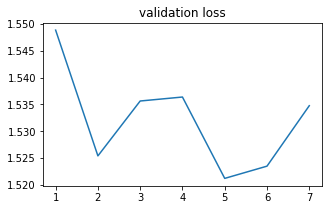

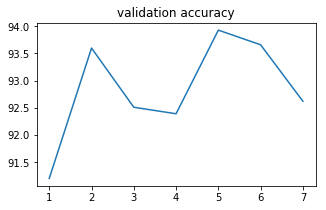

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

Done! We've trained an MLP! Is this a good network? For reference, a test accuracy of below ~97% on MNIST is considered poor.

**task** reimplement using `nn.sequential` and check you get the same result

## MNIST classification using a simple convolutional network

We next extend to a convolutional implementation and investigate whether this boosts training.

First let us redefine our DataLoaders with smaller batch sizes.

In [34]:
train_loader = torch.utils.data.DataLoader(
       mnist_train_dataset, batch_size= 8, shuffle = True)

test_loader = torch.utils.data.DataLoader(
       mnist_test_dataset, batch_size = 8, shuffle = True)

We create a network with 2 convolutional layers with max pooling and relu non-linearities. The output size = [10], since we have 10 classes, and is followed by a softmax layer to ensure the result is a set of probabilities for each class. Softmax is very commonly used as the last layer in classification tasks.


In [35]:
import torch.nn as nn


class MNIST_Model(nn.Module):
    def __init__(self):
        super(MNIST_Model, self).__init__()
    
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout2d(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        self.lin_blocks = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            #nn.Softmax(),
        )
        
    
    def forward(self, x):
        x = self.conv_blocks(x) 
        x = x.view(x.size(0),-1)
        x = self.lin_blocks(x)

        return F.log_softmax(x,dim=1)

    
net = MNIST_Model() #seq_model
print(net)
net = net.to(device)

MNIST_Model(
  (conv_blocks): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout2d(p=0.5, inplace=False)
    (4): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
  )
  (lin_blocks): Sequential(
    (0): Linear(in_features=320, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)


**Task** either get them to change to sequential or get them to implement the conv blocks by themselves fr

### Loss function and optimizer

We again need to define our loss and optimizers. In this case, since we're doing classification, we use **CrossEntropy Loss**, a commonly used loss function for classification.


In [36]:
import torch.optim as optim

loss_fun = nn.CrossEntropyLoss()
loss_fun = loss_fun.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)



### Training 

We will now train our classifer model - this time iterating using enumerate. 

### Task 2 

Implement the training interations - see example from regression task

At each epoch, as before we need to clear gradients first (since they are accumalated at each backward step), then we pass the data through the network to make a prediction, compute loss and gradiets, and finally update the parameters.


In [38]:
epochs = 1
for epoch in range(epochs): 

    # enumerate can be used to output iteration index i, as well as the data 
    for i, (data, labels) in enumerate(train_loader, 0):
        # --------------------------------------------------task 2 ------------------------------------------------------------
        # Task 2: implement training iteration here
        # clear the gradient
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        #feed the input and acquire the output from network
        outputs = net(data)

        #calculating the predicted and the expected loss
        loss = loss_fun(outputs, labels)

        #compute the gradient
        loss.backward()

        #update the parameters
        optimizer.step()
        # ---------------------------------------------------------------------------------------------------------------------

        # print statistics
        ce_loss = loss.item()
        if i % 10 == 0:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, ce_loss))


[1,     1] loss: 0.144
[1,    11] loss: 0.045
[1,    21] loss: 0.003
[1,    31] loss: 0.016
[1,    41] loss: 1.762
[1,    51] loss: 0.225
[1,    61] loss: 1.117
[1,    71] loss: 0.075
[1,    81] loss: 0.016
[1,    91] loss: 0.058
[1,   101] loss: 0.040
[1,   111] loss: 0.036
[1,   121] loss: 0.156
[1,   131] loss: 0.031
[1,   141] loss: 0.894
[1,   151] loss: 0.035
[1,   161] loss: 0.005
[1,   171] loss: 0.084
[1,   181] loss: 0.148
[1,   191] loss: 0.087
[1,   201] loss: 0.100
[1,   211] loss: 0.091
[1,   221] loss: 0.005
[1,   231] loss: 0.024
[1,   241] loss: 0.001
[1,   251] loss: 0.090
[1,   261] loss: 0.943
[1,   271] loss: 0.012
[1,   281] loss: 0.434
[1,   291] loss: 0.009
[1,   301] loss: 0.008
[1,   311] loss: 0.216
[1,   321] loss: 0.009
[1,   331] loss: 1.003
[1,   341] loss: 0.000
[1,   351] loss: 0.098
[1,   361] loss: 0.011
[1,   371] loss: 0.040
[1,   381] loss: 1.251
[1,   391] loss: 0.356
[1,   401] loss: 0.055
[1,   411] loss: 0.052
[1,   421] loss: 0.443
[1,   431] 

[1,  3611] loss: 0.180
[1,  3621] loss: 0.048
[1,  3631] loss: 0.092
[1,  3641] loss: 0.017
[1,  3651] loss: 0.001
[1,  3661] loss: 0.081
[1,  3671] loss: 0.090
[1,  3681] loss: 0.042
[1,  3691] loss: 0.006
[1,  3701] loss: 0.046
[1,  3711] loss: 0.364
[1,  3721] loss: 0.013
[1,  3731] loss: 0.019
[1,  3741] loss: 0.537
[1,  3751] loss: 0.053
[1,  3761] loss: 0.077
[1,  3771] loss: 0.066
[1,  3781] loss: 0.015
[1,  3791] loss: 0.006
[1,  3801] loss: 0.307
[1,  3811] loss: 0.286
[1,  3821] loss: 0.149
[1,  3831] loss: 0.037
[1,  3841] loss: 0.501
[1,  3851] loss: 0.058
[1,  3861] loss: 0.900
[1,  3871] loss: 0.173
[1,  3881] loss: 0.164
[1,  3891] loss: 0.031
[1,  3901] loss: 0.003
[1,  3911] loss: 0.001
[1,  3921] loss: 0.053
[1,  3931] loss: 0.071
[1,  3941] loss: 0.018
[1,  3951] loss: 0.002
[1,  3961] loss: 0.001
[1,  3971] loss: 0.508
[1,  3981] loss: 0.121
[1,  3991] loss: 0.321
[1,  4001] loss: 0.155
[1,  4011] loss: 0.014
[1,  4021] loss: 0.007
[1,  4031] loss: 0.386
[1,  4041] 

[1,  7181] loss: 0.031
[1,  7191] loss: 0.001
[1,  7201] loss: 0.013
[1,  7211] loss: 0.357
[1,  7221] loss: 0.175
[1,  7231] loss: 0.060
[1,  7241] loss: 0.100
[1,  7251] loss: 0.043
[1,  7261] loss: 0.015
[1,  7271] loss: 0.001
[1,  7281] loss: 0.009
[1,  7291] loss: 0.075
[1,  7301] loss: 0.013
[1,  7311] loss: 0.020
[1,  7321] loss: 0.090
[1,  7331] loss: 0.029
[1,  7341] loss: 0.074
[1,  7351] loss: 0.167
[1,  7361] loss: 0.055
[1,  7371] loss: 0.017
[1,  7381] loss: 0.334
[1,  7391] loss: 0.001
[1,  7401] loss: 0.199
[1,  7411] loss: 0.044
[1,  7421] loss: 0.001
[1,  7431] loss: 0.256
[1,  7441] loss: 0.033
[1,  7451] loss: 0.043
[1,  7461] loss: 0.001
[1,  7471] loss: 0.163
[1,  7481] loss: 0.118
[1,  7491] loss: 0.017


### Testing

We will now use our trained network to make a prediction on our test set. 


In [39]:
#make an iterator from test_loader
test_iterator = iter(test_loader)
#Get a batch of testing images
images, labels = test_iterator.next()
images = images.to(device)
labels = labels.to(device)

Predicted:      8     2     6     6     2     6     6     3


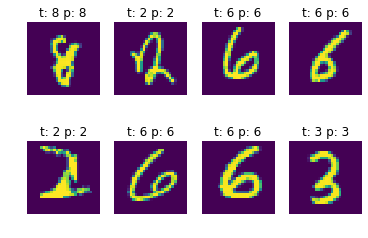

In [40]:
y_score = net(images)
# get predicted class from the class probabilities
_, y_pred = torch.max(y_score, 1)

print('Predicted: ', ' '.join('%5s' % classes[y_pred[j]] for j in range(8)))

# plot y_score - true label (t) vs predicted label (p)
fig2 = plt.figure()
for i in range(8):
    fig2.add_subplot(rows, columns, i+1)
    plt.title('t: ' + classes[labels[i].cpu()] + ' p: ' + classes[y_pred[i].cpu()])
    img = images[i] / 2 + 0.5     # this is to unnormalize the image
    img = torchvision.transforms.ToPILImage()(img.cpu())
    plt.axis('off')
    plt.imshow(img)
plt.show()


### Computing classification scores

We will now use the predictions to compute the accuracy, f1 score, precision and recall. These are scores commonly used to evaluate classification, in particular the f1 score is a good measure for datasets with imbalanced classes.

In [41]:
# first convert tensors to numpy
y_true = labels.data.cpu().numpy()
y_pred = y_pred.data.cpu().numpy()

You can use sklearn classification metrics to calculate the scores - you will need to input the true labels, and predicted classes.

See https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics for more details.

In [42]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
print('accuracy:', accuracy, ', f1 score:', f1, ', precision:', precision, ', recall:', recall)

accuracy: 1.0 , f1 score: 1.0 , precision: 1.0 , recall: 1.0


## References

This tutorial was inspired by https://www.guru99.com/pytorch-tutorial.html

Written by Cher Bass (cher.bass[at].kcl.ac.uk) and Abdulah Fawaz (abdulah.fawaz[at]kcl.ac.uk)
